In [2]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example

from dm_control.locomotion.walkers import rodent
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

#viewer
from dm_control import viewer

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

#other sources
from dm_control.locomotion.examples import basic_rodent_2020 as br

In [3]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
matplotlib.rcParams['animation.ffmpeg_path'] = r"C:\Tools\ffmpeg-master-latest-win64-gpl\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"  # Windows 示例
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
env2=br.rodent_maze_forage
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())
np.random.seed(42)

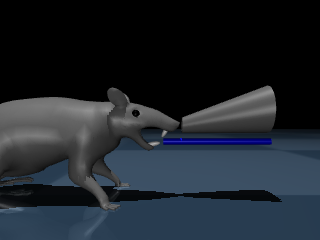

In [4]:
#模型搭建

arena = mjcf.RootElement()  #声明根节点
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid) #添加地板
'''for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2]) #添加光源'''
arena.worldbody.add(
  'camera',
  name='fixed_camera_1',  # 摄像头名称
  pos=[0.14, -0.17, 0.07],        # 摄像头的位置 (x, y, z)
  quat=[0.707, 0.707, 0, 0]     # 摄像头的朝向（四元数，默认朝向 z 轴）
)
arena.worldbody.add(
  'camera',
  name='fixed_camera_2',  
  pos=[0.12, -0.27, 0.07],        
  quat=[0.707, 0.707, 0, 0]    
)

arena.worldbody.add(
  'camera',
  name='fixed_camera_3',  
  pos=[0.08, 0, 0.5],        
  #quat=[0.707, 0.707, 0, 0]    
)

arena.worldbody.add(
  'camera',
  name='fixed_camera_4',  
  pos=[0.38, -0.17, 0.07],        
  quat=[0.612,0.612,0.3535,0.3535]    
)

walker = rodent.Rat(torque_actuators= True, foot_mods=True)
op = mjcf.from_path("op.xml")
wp= mjcf.from_path("wp.xml")

spawn_site = arena.worldbody.add('site', pos=(0.14,0,0.065), group=3)
spawn_site.attach(op)

spawn_site = arena.worldbody.add('site', pos=(0.123,0,0.05), group=3)
spawn_site.attach(wp)

spawn_site = arena.worldbody.add('site', pos=(0,0,0), group=3)
spawn_site.attach(walker.mjcf_model)
  
physics = mjcf.Physics.from_mjcf_model(arena)

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.geomgroup[2] = 0 

physics.named.model.geom_rgba['wp//unnamed_geom_0'] =  [0.0, 0.0, 1.0, 1.0]

physics.step()
PIL.Image.fromarray(physics.render(scene_option=scene_option,camera_id='fixed_camera_2'))
#PIL.Image.fromarray(physics.render(scene_option=scene_option))

In [ ]:
#控制信号生成

from scipy.interpolate import pchip_interpolate
def mandible_qpos():
    total_points = 501
    t_control = np.array([0.0, 0.15, 0.2,  
                         0.3, 0.4, 0.5, 0.6, 0.7, 0.8,  
                         0.85, 1.0])  
    
    y_control = np.array([-0.3, -0.1, 0.07,  
                          0.07, -0.1, 0.07, -0.1, 0.07, -0.1, 
                          -0.2, -0.3])  
    

    t_highres = np.linspace(0, 1, 2000)  
    y_highres = pchip_interpolate(t_control, y_control, t_highres)
    t_final = np.linspace(0, 1, total_points)
    y_final = pchip_interpolate(t_highres, y_highres, t_final)
    
    return y_final

def vc2_extend():
    amplitude = 0.05  
    frequency = 2     
    duration = 1      
    num_points = 501 
    t = np.linspace(0, duration, num_points)
    y = amplitude * np.sin(2 * np.pi * frequency * t)
    return y

def generate_tail_movement_sequence(num_frames=500, duration=1.0):
    t = np.linspace(0, duration, num_frames)  
    freq = 1  
    amplitude = 0.1  
    a1 = amplitude * np.sin(2 * np.pi * freq * t) 
    
    total_points = 501
    rise_points = int(total_points * 0.2)  
    hold_points = int(total_points * 0.6)  
    fall_points = total_points - rise_points - hold_points 

    # 生成控制点列
    rise = np.linspace(0, 0.3, rise_points) 
    hold = np.full(hold_points, 0.3)        
    fall = np.linspace(0.3, 0, fall_points) 
    a2 = np.concatenate([rise, hold, fall])
    
    rise = np.linspace(0, 0.2, rise_points)  
    hold = np.full(hold_points, 0.2)         
    fall = np.linspace(0.2, 0, fall_points)  
    a3 = np.concatenate([rise, hold, fall])
    # 确保最后一帧回到0
    a1[-1] = 0.0
    return a1,a2,a3

# 生成控制信号
y = mandible_qpos()
y2= vc2_extend()
y3,y4,y5 = generate_tail_movement_sequence()
    


In [ ]:
def demo_show(RatSignal,OpSignal_1,OpSignal_2,cmd_duration=1,framerate=60,camera='fixed_camera_1'):
  duration = cmd_duration*len(RatSignal)    # (seconds)
  
  physics.reset()
  frames = []
  t_step=-1
  
  while physics.data.time < duration:
    physics.data.qpos= np.zeros(67)
    if physics.data.time - t_step >= cmd_duration:
      if OpSignal_1[t_step+1]==1:  
        physics.named.model.geom_rgba['op//unnamed_geom_0'] =  [1.0, 0.0, 0.0, 1.0]
      elif OpSignal_2[t_step+1]==1:  
        physics.named.model.geom_rgba['op//unnamed_geom_0'] =  [0.0, 1.0, 0.0, 1.0]
      else:
        physics.named.model.geom_rgba['op//unnamed_geom_0'] =  [0.5, 0.5, 0.5, 1.0]
      if RatSignal[t_step+1]==1:
        act=1
        sub_act=0
      else:
        act=0
    if act==1:
      physics.named.data.qpos['walker/mandible']=y[sub_act]
      physics.named.data.qpos['walker/vertebra_cervical_2_extend']=y2[sub_act]  
      physics.named.data.qpos['walker/vertebra_C1_bend']=y3[sub_act]  
      physics.named.data.qpos['walker/vertebra_C1_extend']=y5[sub_act]
      physics.named.data.qpos['walker/vertebra_C2_extend']=y4[sub_act]
      sub_act+=1
    else:
      physics.named.data.qpos['walker/mandible']=-0.3
    t_step=int(physics.data.time)

    physics.step()

    if len(frames) < (physics.data.time) * framerate:
      pixels = physics.render(camera_id=camera,scene_option=scene_option)
      frames.append(pixels)
  return display_video(frames, framerate)


In [61]:
demo_show(RatSignal=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_1=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_2=[0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1],camera='fixed_camera_3')

In [62]:
demo_show(RatSignal=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_1=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_2=[0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1],camera='fixed_camera_2')

In [63]:
demo_show(RatSignal=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_1=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_2=[0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1],camera='fixed_camera_1')

In [64]:
demo_show(RatSignal=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_1=[0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0],OpSignal_2=[0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1],camera='fixed_camera_4')